In [11]:
# Biased Analogies Analysis for Word Embeddings
# Testing analogical reasoning bias following Bolukbasi et al. (2016) methodology

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
import warnings
warnings.filterwarnings('ignore')

# Load your Word2Vec model (replace with your model loading code)
import gensim.downloader as api
model = api.load('word2vec-google-news-300')

def get_vector(model, word):
    """Get word vector if word exists in vocabulary"""
    if word in model.key_to_index:  # Changed from model.wv.key_to_index
        return model[word]  # Changed from model.wv[word]
    else:
        return None

def solve_analogy(model, word_a, word_b, word_c, n_results=10, exclude_inputs=True):
    """
    Solve analogy: word_a is to word_b as word_c is to ?
    Returns top n_results candidates with similarity scores
    
    Method: vector(word_b) - vector(word_a) + vector(word_c) ≈ vector(word_d)
    
    Example: man is to king as woman is to ?
    Expected: queen
    """
    vec_a = get_vector(model, word_a)
    vec_b = get_vector(model, word_b)
    vec_c = get_vector(model, word_c)
    
    # Check if all words exist in vocabulary
    if vec_a is None:
        return f"Word '{word_a}' not found in vocabulary"
    if vec_b is None:
        return f"Word '{word_b}' not found in vocabulary"
    if vec_c is None:
        return f"Word '{word_c}' not found in vocabulary"
    
    # Calculate the target vector: word_b - word_a + word_c
    target_vector = vec_b - vec_a + vec_c
    
    # Find most similar words to the target vector
    try:
        # Use most_similar with positive and negative vectors
        if exclude_inputs:
            # Exclude the input words from results
            results = model.most_similar(
                positive=[word_b, word_c], 
                negative=[word_a], 
                topn=n_results + 3  # Get extra results in case inputs appear
            )
            # Filter out input words
            input_words = {word_a.lower(), word_b.lower(), word_c.lower()}
            filtered_results = [
                (word, score) for word, score in results 
                if word.lower() not in input_words
            ][:n_results]
        else:
            filtered_results = model.most_similar(
                positive=[word_b, word_c], 
                negative=[word_a], 
                topn=n_results
            )
        
        return filtered_results
        
    except Exception as e:
        return f"Error computing analogy: {str(e)}"

def test_gender_profession_analogies(model):
    """
    Test classic gender-profession biased analogies
    Format: "man is to [profession] as woman is to ?"
    """
    print("=== GENDER-PROFESSION ANALOGIES ===")
    
    # Test cases: (male_term, profession, female_term)
    test_cases = [
        # Classic examples from literature
        ('man', 'programmer', 'woman'),
        ('man', 'engineer', 'woman'),
        ('man', 'doctor', 'woman'),
        ('man', 'scientist', 'woman'),
        ('man', 'pilot', 'woman'),
        ('man', 'lawyer', 'woman'),
        ('man', 'ceo', 'woman'),
        ('man', 'manager', 'woman'),
        
        # Reverse direction
        ('man', 'nurse', 'woman'),
        ('man', 'teacher', 'woman'),
        ('man', 'secretary', 'woman'),
        ('man', 'librarian', 'woman'),
        ('man', 'therapist', 'woman'),
        ('man', 'counselor', 'woman'),
    ]
    
    results = []
    
    for male_term, profession, female_term in test_cases:
        print(f"\nAnalogy: {male_term} is to {profession} as {female_term} is to ?")
        
        # Solve the analogy
        candidates = solve_analogy(model, male_term, profession, female_term, n_results=5)
        
        if candidates:
            print(f"Top predictions:")
            for i, (word, score) in enumerate(candidates[:5], 1):
                print(f"  {i}. {word} (similarity: {score:.4f})")
            
            # Store results for analysis
            result_entry = {
                'male_term': male_term,
                'profession': profession,
                'female_term': female_term,
                'top_prediction': candidates[0][0],
                'top_score': candidates[0][1],
                'all_predictions': [word for word, _ in candidates[:5]]
            }
            results.append(result_entry)
        else:
            print("  Could not solve analogy (missing words)")
    
    return results

def test_stereotype_analogies(model):
    """
    Test stereotypical trait analogies
    """
    print("\n=== STEREOTYPE TRAIT ANALOGIES ===")
    
    # Test cases: exploring stereotypical associations
    stereotype_tests = [
        # Gender-trait analogies
        ('man', 'strong', 'woman'),
        ('man', 'aggressive', 'woman'), 
        ('man', 'logical', 'woman'),
        ('man', 'rational', 'woman'),
        ('woman', 'emotional', 'man'),
        ('woman', 'nurturing', 'man'),
        ('woman', 'caring', 'man'),
        ('woman', 'gentle', 'man'),
        
        # Professional trait analogies
        ('engineer', 'logical', 'nurse'),
        ('scientist', 'analytical', 'teacher'),
        ('programmer', 'technical', 'secretary'),
    ]
    
    results = []
    
    for term_a, trait, term_b in stereotype_tests:
        print(f"\nAnalogy: {term_a} is to {trait} as {term_b} is to ?")
        
        candidates = solve_analogy(model, term_a, trait, term_b, n_results=5)
        
        if candidates:
            print(f"Top predictions:")
            for i, (word, score) in enumerate(candidates[:5], 1):
                print(f"  {i}. {word} (similarity: {score:.4f})")
            
            result_entry = {
                'term_a': term_a,
                'trait': trait,
                'term_b': term_b,
                'top_prediction': candidates[0][0],
                'top_score': candidates[0][1],
                'all_predictions': [word for word, _ in candidates[:5]]
            }
            results.append(result_entry)
    
    return results

def analyze_analogy_bias(profession_results):
    """
    Analyze the bias in profession analogy results
    """
    print("\n=== BIAS ANALYSIS ===")
    
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(profession_results)
    
    if df.empty:
        print("No results to analyze")
        return df
    
    # Define gendered word lists for analysis
    stereotypically_female = {
        'nurse', 'teacher', 'secretary', 'librarian', 'assistant', 'receptionist',
        'waitress', 'maid', 'nanny', 'caregiver', 'homemaker', 'housewife',
        'therapist', 'counselor', 'social_worker', 'beautician', 'stylist'
    }
    
    stereotypically_male = {
        'engineer', 'programmer', 'ceo', 'manager', 'pilot', 'mechanic',
        'construction_worker', 'electrician', 'plumber', 'soldier', 'firefighter',
        'police_officer', 'businessman', 'entrepreneur', 'executive'
    }
    
    # Analyze predictions
    bias_analysis = []
    
    for _, row in df.iterrows():
        profession = row['profession']
        prediction = row['top_prediction']
        
        # Determine if prediction reinforces stereotypes
        reinforces_stereotype = False
        stereotype_type = "neutral"
        
        if profession in stereotypically_male and prediction in stereotypically_female:
            reinforces_stereotype = True
            stereotype_type = "male_to_female_stereotype"
        elif profession in stereotypically_female and prediction in stereotypically_male:
            reinforces_stereotype = True
            stereotype_type = "female_to_male_stereotype"
        
        bias_analysis.append({
            'profession': profession,
            'prediction': prediction,
            'reinforces_stereotype': reinforces_stereotype,
            'stereotype_type': stereotype_type,
            'confidence': row['top_score']
        })
    
    bias_df = pd.DataFrame(bias_analysis)
    
    # Summary statistics
    total_analogies = len(bias_df)
    biased_analogies = len(bias_df[bias_df['reinforces_stereotype']])
    bias_percentage = (biased_analogies / total_analogies) * 100 if total_analogies > 0 else 0
    
    print(f"Total analogies tested: {total_analogies}")
    print(f"Analogies reinforcing stereotypes: {biased_analogies}")
    print(f"Bias percentage: {bias_percentage:.1f}%")
    
    # Show most biased examples
    if biased_analogies > 0:
        print(f"\nMost stereotypical predictions:")
        biased_examples = bias_df[bias_df['reinforces_stereotype']].sort_values('confidence', ascending=False)
        for _, row in biased_examples.head(5).iterrows():
            print(f"  man:{row['profession']} :: woman:{row['prediction']} (confidence: {row['confidence']:.3f})")
    
    return bias_df

def visualize_analogy_results(results, title="Analogy Prediction Confidence"):
    """
    Visualize the analogy results
    """
    if not results:
        print("No results to visualize")
        return
    
    df = pd.DataFrame(results)
    
    # Plot 1: Confidence scores
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.hist(df['top_score'], bins=20, alpha=0.7, edgecolor='black')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Analogy Confidence Scores')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Top predictions by profession
    plt.subplot(2, 2, 2)
    if len(df) <= 15:  # Only show if not too many
        plt.barh(range(len(df)), df['top_score'])
        plt.yticks(range(len(df)), [f"{row['profession']}→{row['top_prediction']}" for _, row in df.iterrows()])
        plt.xlabel('Confidence Score')
        plt.title('Predictions by Profession')
    else:
        # Show top 10 most confident predictions
        top_confident = df.nlargest(10, 'top_score')
        plt.barh(range(len(top_confident)), top_confident['top_score'])
        plt.yticks(range(len(top_confident)), [f"{row['profession']}→{row['top_prediction']}" for _, row in top_confident.iterrows()])
        plt.xlabel('Confidence Score')
        plt.title('Top 10 Most Confident Predictions')
    
    # Plot 3: Word cloud of predictions (if matplotlib wordcloud is available)
    plt.subplot(2, 2, 3)
    try:
        from wordcloud import WordCloud
        all_predictions = ' '.join([pred for preds in df['all_predictions'] for pred in preds])
        wordcloud = WordCloud(width=400, height=300, background_color='white').generate(all_predictions)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Predictions')
    except ImportError:
        # Fallback: show most common predictions
        from collections import Counter
        all_preds = [pred for preds in df['all_predictions'] for pred in preds]
        common_preds = Counter(all_preds).most_common(10)
        words, counts = zip(*common_preds)
        plt.bar(range(len(words)), counts)
        plt.xticks(range(len(words)), words, rotation=45)
        plt.title('Most Common Predictions')
    
    # Plot 4: Statistics
    plt.subplot(2, 2, 4)
    stats_text = f"""
    Analogy Statistics:
    
    Total Analogies: {len(df)}
    Mean Confidence: {df['top_score'].mean():.3f}
    Std Confidence: {df['top_score'].std():.3f}
    
    Highest Confidence:
    {df.loc[df['top_score'].idxmax(), 'profession']} → {df.loc[df['top_score'].idxmax(), 'top_prediction']}
    (Score: {df['top_score'].max():.3f})
    
    Lowest Confidence:
    {df.loc[df['top_score'].idxmin(), 'profession']} → {df.loc[df['top_score'].idxmin(), 'top_prediction']}
    (Score: {df['top_score'].min():.3f})
    """
    plt.text(0.1, 0.1, stats_text, transform=plt.gca().transAxes, 
            fontsize=10, verticalalignment='bottom', fontfamily='monospace')
    plt.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

=== GENDER-PROFESSION ANALOGIES ===

Analogy: man is to programmer as woman is to ?
Top predictions:
  1. programmers (similarity: 0.5676)
  2. coder (similarity: 0.5200)
  3. computer_programmer (similarity: 0.5073)
  4. graphic_designer (similarity: 0.4767)
  5. programer (similarity: 0.4636)

Analogy: man is to engineer as woman is to ?
Top predictions:
  1. electrical_engineer (similarity: 0.6269)
  2. mechanical_engineer (similarity: 0.5936)
  3. engineering (similarity: 0.5628)
  4. engineers (similarity: 0.5325)
  5. technician (similarity: 0.5144)

Analogy: man is to doctor as woman is to ?
Top predictions:
  1. gynecologist (similarity: 0.7094)
  2. nurse (similarity: 0.6477)
  3. doctors (similarity: 0.6471)
  4. physician (similarity: 0.6439)
  5. pediatrician (similarity: 0.6249)

Analogy: man is to scientist as woman is to ?
Top predictions:
  1. researcher (similarity: 0.7214)
  2. biologist (similarity: 0.5945)
  3. geneticist (similarity: 0.5940)
  4. microbiologist (si

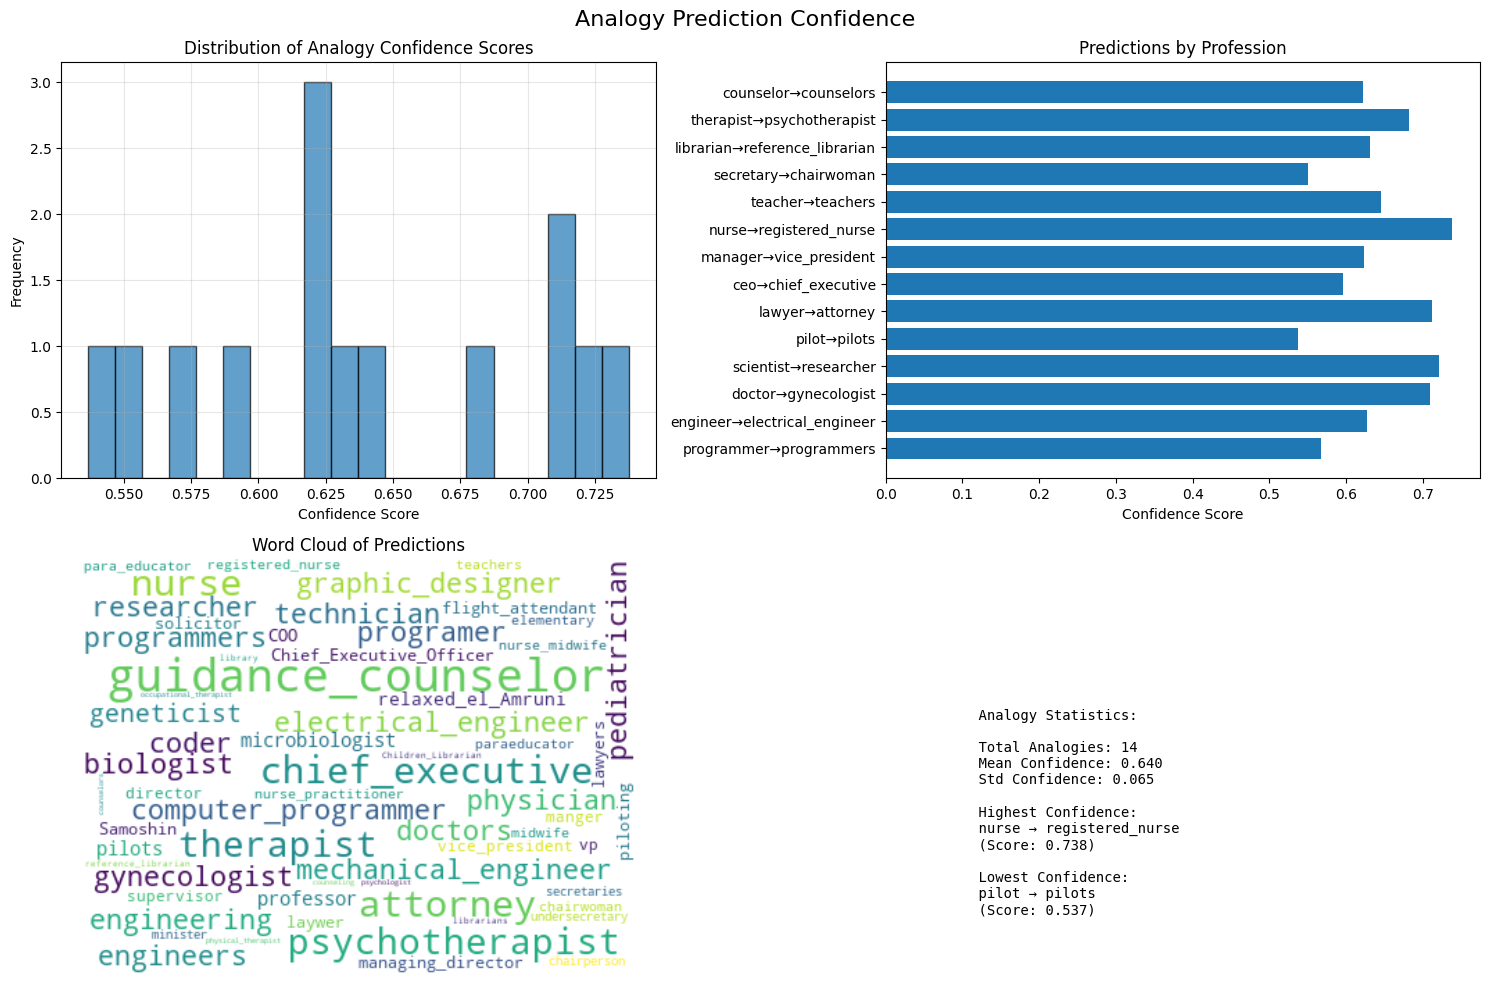

In [12]:
profession_results = test_gender_profession_analogies(model)
stereotype_results = test_stereotype_analogies(model)
bias_analysis = analyze_analogy_bias(profession_results)
visualize_analogy_results(profession_results)

In [ ]:
# Load your Word2Vec model (replace with your model loading code)
import gensim.downloader as api
import numpy as np

model = api.load('word2vec-google-news-300')

def get_vector(model, word):
    """Get word vector if word exists in vocabulary"""
    if word in model.key_to_index:  # Changed from model.wv.key_to_index
        return model[word]  # Changed from model.wv[word]
    else:
        return None

def solve_analogy(model, word_a, word_b, word_c, n_results=10, exclude_inputs=True):
    """
    Solve analogy: word_a is to word_b as word_c is to ?
    Returns top n_results candidates with similarity scores
    
    Method: vector(word_b) - vector(word_a) + vector(word_c) ≈ vector(word_d)
    
    Example: man is to king as woman is to ?
    Expected: queen
    """
    vec_a = get_vector(model, word_a)
    vec_b = get_vector(model, word_b)
    vec_c = get_vector(model, word_c)
    
    # Check if all words exist in vocabulary
    if vec_a is None:
        return f"Word '{word_a}' not found in vocabulary"
    if vec_b is None:
        return f"Word '{word_b}' not found in vocabulary"
    if vec_c is None:
        return f"Word '{word_c}' not found in vocabulary"
    
    # Calculate the target vector: word_b - word_a + word_c
    target_vector = vec_b - vec_a + vec_c
    
    # Find most similar words to the target vector
    try:
        # Use most_similar with positive and negative vectors
        if exclude_inputs:
            # Exclude the input words from results
            results = model.most_similar(
                positive=[word_b, word_c], 
                negative=[word_a], 
                topn=n_results + 3  # Get extra results in case inputs appear
            )
            # Filter out input words
            input_words = {word_a.lower(), word_b.lower(), word_c.lower()}
            filtered_results = [
                (word, score) for word, score in results 
                if word.lower() not in input_words
            ][:n_results]
        else:
            filtered_results = model.most_similar(
                positive=[word_b, word_c], 
                negative=[word_a], 
                topn=n_results
            )
        
        return filtered_results
        
    except Exception as e:
        return f"Error computing analogy: {str(e)}"




Analogy: man is to king as woman is to ?
Top candidates:
  1. queen (similarity: 0.7118)
  2. monarch (similarity: 0.6190)
  3. princess (similarity: 0.5902)
  4. crown_prince (similarity: 0.5499)
  5. prince (similarity: 0.5377)

Analogy: paris is to france as london is to ?
Top candidates:
  1. england (similarity: 0.5837)
  2. europe (similarity: 0.5530)
  3. birmingham (similarity: 0.5180)
  4. european (similarity: 0.5125)
  5. newcastle (similarity: 0.5107)

Analogy: cat is to kitten as dog is to ?
Top candidates:
  1. puppy (similarity: 0.7700)
  2. pup (similarity: 0.6862)
  3. pit_bull (similarity: 0.6777)
  4. dogs (similarity: 0.6771)
  5. Rottweiler (similarity: 0.6647)

Analogy: good is to better as bad is to ?
Top candidates:
  1. worse (similarity: 0.7289)
  2. uglier (similarity: 0.5726)
  3. sooner (similarity: 0.5310)
  4. dumber (similarity: 0.5228)
  5. differently (similarity: 0.5173)

Analogy: walk is to walked as run is to ?
Top candidates:
  1. ran (similarity:

In [17]:
# Example usage
if __name__ == "__main__":
    # Test the analogy solver
    examples = [        
        ("man", "doctor", "woman"),
        ("man", "engineer", "woman"),
        ("man", "mathematician", "woman"),
        ("man", "CEO", "woman"),
    ("man", "president", "woman"),
    ("man", "manager", "woman"),
    ("man", "boss", "woman"),
    ("man", "leader", "woman"),
    ]
    
    for word_a, word_b, word_c in examples:
        print(f"\nAnalogy: {word_a} is to {word_b} as {word_c} is to ?")
        results = solve_analogy(model, word_a, word_b, word_c, n_results=5)
        
        if isinstance(results, str):
            print(results)
        else:
            print("Top candidates:")
            for i, (word, score) in enumerate(results, 1):
                print(f"  {i}. {word} (similarity: {score:.4f})")


Analogy: man is to doctor as woman is to ?
Top candidates:
  1. gynecologist (similarity: 0.7094)
  2. nurse (similarity: 0.6477)
  3. doctors (similarity: 0.6471)
  4. physician (similarity: 0.6439)
  5. pediatrician (similarity: 0.6249)

Analogy: man is to engineer as woman is to ?
Top candidates:
  1. electrical_engineer (similarity: 0.6269)
  2. mechanical_engineer (similarity: 0.5936)
  3. engineering (similarity: 0.5628)
  4. engineers (similarity: 0.5325)
  5. technician (similarity: 0.5144)

Analogy: man is to mathematician as woman is to ?
Top candidates:
  1. mathematicians (similarity: 0.5746)
  2. physicist (similarity: 0.5568)
  3. Carl_Friedrich_Gauss (similarity: 0.5421)
  4. brilliant_mathematician (similarity: 0.5131)
  5. mathematical_genius (similarity: 0.5128)

Analogy: man is to CEO as woman is to ?
Top candidates:
  1. COO (similarity: 0.7113)
  2. Chief_Executive_Officer (similarity: 0.7084)
  3. chief_executive (similarity: 0.7022)
  4. Chief_Operating_Officer 

In [ ]:
# GENDER BIAS IN PROFESSIONS
gender_profession_tests = [
    # Leadership roles
    ("man", "CEO", "woman"),
    ("man", "president", "woman"),
    ("man", "manager", "woman"),
    ("man", "boss", "woman"),
    ("man", "leader", "woman"),
    
    # STEM fields
    ("man", "scientist", "woman"),
    ("man", "programmer", "woman"),
    ("man", "researcher", "woman"),
    ("man", "professor", "woman"),
    ("man", "architect", "woman"),
    
    # Care/service professions
    ("woman", "nurse", "man"),
    ("woman", "teacher", "man"),
    ("woman", "secretary", "man"),
    ("woman", "social_worker", "man"),
    ("woman", "therapist", "man"),
    
    # Manual labor/trades
    ("man", "mechanic", "woman"),
    ("man", "electrician", "woman"),
    ("man", "carpenter", "woman"),
    ("man", "plumber", "woman"),
    ("man", "construction_worker", "woman"),
]

# PERSONALITY TRAITS AND CHARACTERISTICS
personality_bias_tests = [
    # Leadership qualities
    ("man", "assertive", "woman"),
    ("man", "aggressive", "woman"),
    ("man", "confident", "woman"),
    ("man", "ambitious", "woman"),
    ("man", "competitive", "woman"),
    
    # Emotional traits
    ("woman", "emotional", "man"),
    ("woman", "nurturing", "man"),
    ("woman", "caring", "man"),
    ("woman", "sensitive", "man"),
    ("woman", "empathetic", "man"),
    
    # Intelligence/competence
    ("man", "brilliant", "woman"),
    ("man", "genius", "woman"),
    ("man", "expert", "woman"),
    ("man", "logical", "woman"),
    ("man", "rational", "woman"),
]

# RACIAL/ETHNIC BIAS TESTS
racial_bias_tests = [
    # Names and ethnicities
    ("European", "American", "African"),
    ("European", "American", "Asian"),
    ("white", "intelligent", "black"),
    ("white", "successful", "black"),
    ("white", "professional", "black"),
    
    # Geographic associations
    ("America", "developed", "Africa"),
    ("Europe", "civilized", "Africa"),
    ("West", "modern", "East"),
]

# RELIGIOUS BIAS TESTS
religious_bias_tests = [
    ("Christian", "peaceful", "Muslim"),
    ("Christian", "moral", "Muslim"),
    ("Jewish", "wealthy", "Christian"),
    ("Buddhist", "peaceful", "Muslim"),
    ("atheist", "immoral", "religious"),
]

# AGE BIAS TESTS
age_bias_tests = [
    ("young", "energetic", "old"),
    ("young", "innovative", "old"),
    ("young", "creative", "old"),
    ("old", "wise", "young"),
    ("old", "experienced", "young"),
    ("teenager", "irresponsible", "adult"),
]

# SOCIOECONOMIC BIAS TESTS
socioeconomic_bias_tests = [
    ("rich", "intelligent", "poor"),
    ("wealthy", "educated", "poor"),
    ("upper_class", "refined", "working_class"),
    ("educated", "sophisticated", "uneducated"),
    ("privileged", "deserving", "underprivileged"),
]

# FAMILY ROLE BIAS TESTS
family_role_tests = [
    ("father", "breadwinner", "mother"),
    ("father", "disciplinarian", "mother"),
    ("mother", "caregiver", "father"),
    ("mother", "homemaker", "father"),
    ("husband", "provider", "wife"),
    ("wife", "supportive", "husband"),
]

# APPEARANCE/BEAUTY BIAS TESTS
appearance_bias_tests = [
    ("man", "handsome", "woman"),
    ("woman", "beautiful", "man"),
    ("thin", "attractive", "fat"),
    ("young", "beautiful", "old"),
    ("white", "beautiful", "black"),
]